# Report 2 (end-semester) - Physical Activity Monitoring Dataset

### Table of Content
- 1.0 Introduction
- 1.1 Specific Requirements for this report
- 1.2 Importing all the necessary python modules
- 1.3 1.3 Loading and data wrangling

- 2.0 Data preparation and cleaning (fix, replace, drop) of values
- 2.1 Defining a Data Treatment Function
- 2.2 Calculating Resultant Acceleration and Resultant Angular Velocity

- 3.0 Exploratory Data Analysis And Visualizations
- 3.1 Balance Analysis
- 3.2 Data Splitting
- 3.3 Summary Statistics
- 3.4 Heart Rate Anlysis
- 3.5 Tempature Analysis
- 3.6 Acceleration analysis
- 3.7 Angular velocity analysis
- 3.8 Sensor Analysis
- 3.8.1 Correleation analysis for all the sensor data

- 4.0 Hypothesis testing
- 4.1.1 Hypothesis 1 
- 4.1.2 Hypothesis 2
- 4.1.3 Hypothesis 3

- 5.0 Modelling
- 5.1 Importing all necessary modelling modules
- 5.2 Data preparation and function defination for model
- 5.3 Dimensionality reduction using Principal Component Analysis(PCA)
- 5.4 SVC model using PCA
- 5.5 SVC model without using PCA
- 5.6 Random Forest vs Logistic Regression model
- 5.6.1 Random Forest Classifier Model
- 5.6.2 Logistic Regression Model
- 5.7.1 Applying random forest classifier to our dataset, without gyroscope data
- 5.7.2 Applying random forest classifier to our dataset, without temperature sensor data
- 5.8 Location of Hardware/sensors
- 5.8.1 Applying random forest classifier to our dataset, for hand-held hardware
- 5.8.2 Applying random forest classifier to our dataset, for ankle-held hardware
- 5.8.3 Applying random forest classifier to our dataset, for chest-held hardware

- 6.0 Conclusion

## 1.0 Introduction

The objective of this report is to come up with actionable insights from the datasets generated by hardware and/or software worn by subjects. The developed hardware and/or software can determine the amount (using start/end times and heart rates) and type of physical activity carried out by an individual (or subject).

The Physical Activity Monitoring dataset used for this report contains data of 18 different physical activities (such as walking, cycling, playing soccer etc) performed by 9 subjects wearing 3 inertial measurement units (IMU) and a heart rate monitor. This data is stored in individual text files per subject. Each row in each file represents one reading and contains 54 attributes (including timestamp, activity ID, heart rate and IMU sensory data). Among 18 phyiscal activities only 12 activities are protocol activities and we will be focusing only on this 12 activities and our final aim will be to find a suitable machine learning model to predict which type of physical activity a person is doing among this 12 activities

### 1.1 Specific Requirements for this report:
1. Carry out thorough exploratory data analysis and appropriately handle missing or dirty data.
2. Develop and test at least one hypothesis for a relationship between a single pair of attributes.
3. Develop and test at least one model which uses multiple attributes to make predictions.

### 1.2 Importing all the necessary python modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

from pylab import rcParams
#rcParams['figure.figsize'] = 12,6

import scipy
from scipy.stats import pearsonr
from scipy.stats import spearmanr

%matplotlib inline
# plt.style.use('seaborn-whitegrid')
from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

### 1.3 Loading and data wrangling

In [2]:
# Loading data
allFiles_list = ['PAMAP2_Dataset/Protocol/subject101.dat',
                 'PAMAP2_Dataset/Protocol/subject102.dat',
                 'PAMAP2_Dataset/Protocol/subject103.dat',
                 'PAMAP2_Dataset/Protocol/subject104.dat',
                 'PAMAP2_Dataset/Protocol/subject105.dat',
                 'PAMAP2_Dataset/Protocol/subject106.dat',
                 'PAMAP2_Dataset/Protocol/subject107.dat',
                 'PAMAP2_Dataset/Protocol/subject108.dat',
                 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

# An activity id dictonary is created based on the dataset
activityID_dict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

# Naming columns
col_1to3 = ["timestamp", "activityID","heartRate"]

IMU_Hand = ['handTemperature', 
           'handAcceleration16_1', 'handAcceleration16_2', 'handAcceleration16_3', 
           'handAcceleration06_1', 'handAcceleration06_2', 'handAcceleration06_3', 
           'handGyroscope1', 'handGyroscope2', 'handGyroscope3', 
           'handMagnetometer1', 'handMagnetometer2', 'handMagnetometer3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMU_Chest = ['chestTemperature', 
           'chestAcceleration16_1', 'chestAcceleration16_2', 'chestAcceleration16_3', 
           'chestAcceleration06_1', 'chestAcceleration06_2', 'chestAcceleration06_3', 
           'chestGyroscope1', 'chestGyroscope2', 'chestGyroscope3', 
           'chestMagnetometer1', 'chestMagnetometer2', 'chestMagnetometer3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMU_Ankle = ['ankleTemperature', 
           'ankleAcceleration16_1', 'ankleAcceleration16_2', 'ankleAcceleration16_3', 
           'ankleAcceleration06_1', 'ankleAcceleration06_2', 'ankleAcceleration06_3', 
           'ankleGyroscope1', 'ankleGyroscope2', 'ankleGyroscope3', 
           'ankleMagnetometer1', 'ankleMagnetometer2', 'ankleMagnetometer3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = col_1to3 + IMU_Hand + IMU_Chest + IMU_Ankle

In [3]:
# # Assuming we want to capture the activity name from the numeric id
# activityID_dictReverse = {}
# for key in activityID_dict.keys():
#     value = activityID_dict.get(key)
#     activityID_dictReverse[value] = key
# activityID_dictReverse

In [4]:
print(columns)

['timestamp', 'activityID', 'heartRate', 'handTemperature', 'handAcceleration16_1', 'handAcceleration16_2', 'handAcceleration16_3', 'handAcceleration06_1', 'handAcceleration06_2', 'handAcceleration06_3', 'handGyroscope1', 'handGyroscope2', 'handGyroscope3', 'handMagnetometer1', 'handMagnetometer2', 'handMagnetometer3', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4', 'chestTemperature', 'chestAcceleration16_1', 'chestAcceleration16_2', 'chestAcceleration16_3', 'chestAcceleration06_1', 'chestAcceleration06_2', 'chestAcceleration06_3', 'chestGyroscope1', 'chestGyroscope2', 'chestGyroscope3', 'chestMagnetometer1', 'chestMagnetometer2', 'chestMagnetometer3', 'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4', 'ankleTemperature', 'ankleAcceleration16_1', 'ankleAcceleration16_2', 'ankleAcceleration16_3', 'ankleAcceleration06_1', 'ankleAcceleration06_2', 'ankleAcceleration06_3', 'ankleGyroscope1', 'ankleGyroscope2', 'ankleGyroscop

In [5]:
# loading the data from all separate files into one pandas DataFrame
dfRaw = pd.DataFrame()
for file in allFiles_list:
    subject = pd.read_table(file, header=None, sep='\s+')
    subject.columns = columns
    subject['subject_id'] = int(file[-5])
    dfRaw = pd.concat([dfRaw, subject], ignore_index=True, axis=0)

dfRaw.reset_index(drop=True, inplace=True)

pd.set_option('display.max_columns',None)  #to display all columns
dfRaw

,timestamp,activityID,heartRate,handTemperature,handAcceleration16_1,handAcceleration16_2,handAcceleration16_3,handAcceleration06_1,handAcceleration06_2,handAcceleration06_3,handGyroscope1,handGyroscope2,handGyroscope3,handMagnetometer1,handMagnetometer2,handMagnetometer3,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestAcceleration16_1,chestAcceleration16_2,chestAcceleration16_3,chestAcceleration06_1,chestAcceleration06_2,chestAcceleration06_3,chestGyroscope1,chestGyroscope2,chestGyroscope3,chestMagnetometer1,chestMagnetometer2,chestMagnetometer3,chestOrientation1,chestOrientation2,chestOrientation3,chestOrientation4,ankleTemperature,ankleAcceleration16_1,ankleAcceleration16_2,ankleAcceleration16_3,ankleAcceleration06_1,ankleAcceleration06_2,ankleAcceleration06_3,ankleGyroscope1,ankleGyroscope2,ankleGyroscope3,ankleMagnetometer1,ankleMagnetometer2,ankleMagnetometer3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.000000,0.000000,0.000000,0.000000,31.8125,0.238080,9.80003,-1.688960,0.265304,9.81549,-1.413440,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.000000,0.000000,0.000000,0.000000,30.3125,9.65918,-1.655690,-0.099797,9.64689,-1.555760,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,1
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047759,0.006474,14.8991,-69.2224,-5.82311,1.000000,0.000000,0.000000,0.000000,31.8125,0.319530,9.61282,-1.493280,0.234939,9.78539,-1.428460,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.000000,0.000000,0.000000,0.000000,30.3125,9.69370,-1.579020,-0.215687,9.61670,-1.616300,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,1
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.000000,0.000000,0.000000,0.000000,31.8125,0.235593,9.72421,-1.766210,0.173850,9.72528,-1.518940,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.000000,0.000000,0.000000,0.000000,30.3125,9.58944,-1.732760,0.092914,9.63173,-1.586050,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,1
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.000000,0.000000,0.000000,0.000000,31.8125,0.388697,9.53572,-1.724100,0.157969,9.64994,-1.579520,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.000000,0.000000,0.000000,0.000000,30.3125,9.58814,-1.770400,0.054545,9.63197,-1.631350,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,1
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.000000,0.000000,0.000000,0.000000,31.8125,0.315800,9.49908,-1.609140,0.233506,9.57411,-1.444180,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.000000,0.000000,0.000000,0.000000,30.3125,9.69771,-1.656250,-0.060809,9.64699,-1.646470,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,1.784060,0.087985,0.934673,21.1701,-35.3878,-34.04430,0.558630,-0.593878,0.292228,0.499844,32.3750,2.926640,10.21030,-0.983335,3.125630,10.62120,0.642058,-0.034671,-0.222172,-0.191336,15.599100,-40.9116,14.9966,0.625172,-0.760781,-0.039443,-0.169753,31.5000,9.38737,-0.565040,-3.273700,9.09401,-0.228554,-2.687700,-0.037788,-0.0626

The dimensions of our aggregated data frame shows almost 3 million rows. And from the first five rows displayed above, we already see 4 missing values at column three (heartRate column). Hence, the need to do some data treatment is evident.

## 2.0 Data preparation and cleaning (fix, replace, drop) of values

In [6]:
# Inspect dataframe for variable type
dfRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              float64
 1   activityID             int64  
 2   heartRate              float64
 3   handTemperature        float64
 4   handAcceleration16_1   float64
 5   handAcceleration16_2   float64
 6   handAcceleration16_3   float64
 7   handAcceleration06_1   float64
 8   handAcceleration06_2   float64
 9   handAcceleration06_3   float64
 10  handGyroscope1         float64
 11  handGyroscope2         float64
 12  handGyroscope3         float64
 13  handMagnetometer1      float64
 14  handMagnetometer2      float64
 15  handMagnetometer3      float64
 16  handOrientation1       float64
 17  handOrientation2       float64
 18  handOrientation3       float64
 19  handOrientation4       float64
 20  chestTemperature       float64
 21  chestAcceleration16_1  float64
 22  chestAcceleration1

Visualizing missing values in the dataset

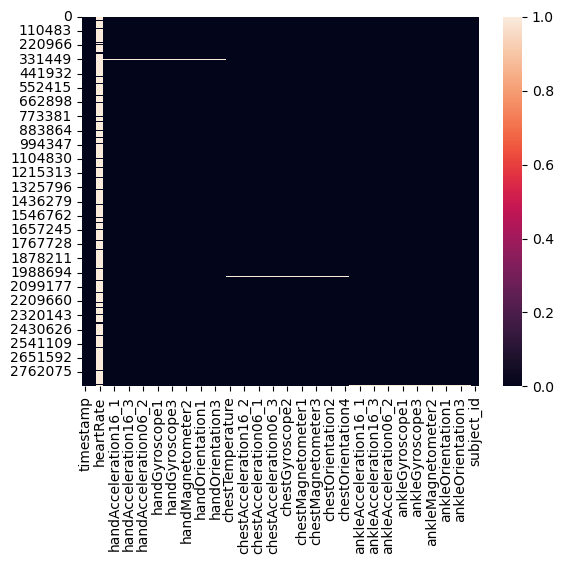

In [7]:
sns.heatmap(dfRaw.isnull())
plt.show()

In [8]:
#Checking the null percentage for each column
round(dfRaw.isnull().sum().sort_values(ascending=False)/len(dfRaw) * 100,2)

heartRate                90.87
handOrientation3          0.46
handGyroscope1            0.46
handOrientation4          0.46
handOrientation2          0.46
handOrientation1          0.46
handMagnetometer3         0.46
handMagnetometer2         0.46
handGyroscope3            0.46
handGyroscope2            0.46
handMagnetometer1         0.46
handAcceleration06_3      0.46
handAcceleration06_2      0.46
handAcceleration06_1      0.46
handAcceleration16_3      0.46
handAcceleration16_2      0.46
handAcceleration16_1      0.46
handTemperature           0.46
ankleOrientation4         0.41
ankleAcceleration16_1     0.41
ankleAcceleration16_2     0.41
ankleAcceleration16_3     0.41
ankleAcceleration06_1     0.41
ankleAcceleration06_2     0.41
ankleAcceleration06_3     0.41
ankleGyroscope1           0.41
ankleOrientation2         0.41
ankleOrientation3         0.41
ankleGyroscope2           0.41
ankleGyroscope3           0.41
ankleMagnetometer1        0.41
ankleMagnetometer2        0.41
ankleMag

### 2.1 Defining a Data Treatment Function

All columns except 3 (timestamp, activityID and subject_id) have varrying proportions of null/missing values. However, the largest proportion (over 90%) of null values was found in the heart rate (HR) column. As explained in the $readme file$, since data is given every 0.01s (due to the fact that the IMUs have a sampling frequency of 100Hz), and the sampling frequency of the HR-monitor was only approximately 9Hz, the missing HR-values were also indicated with NaN in the data-files.

Running and rope jumping are the two most strenuous of the 12 activities listed, and 9Hz is still enough to capture all the variations in IMU data (acceleration oscillations and angular velocity oscillations), as the fastest runners in the world use less than 4 hand and ankle oscillations per second and the fastest skippers in the world use less than 7 oscillations per second, respectively.

Hence, dropping this missing data for HR would have no negative impact on our analysis. Eliminating the 9 missing values for every 10 possible value is tantamount to making the timestamp to almost 0.1 second instead of 0.01 seconds.

Also, following the instructions from the $readme file$, data marked with activityID=0 should be ignored. This information primarily relates to transitional activities, such as moving from one site to the next activity's location or waiting for some equipment to be prepared. Additionally, different portions of one subject's recording were joined together during these transitory activities (noticeable by some "jumping" in the heart rate - data in the event that data collection was abandoned for whatever reason).

Based on information on the $readme file$, we would be dropping data from accelerometer with scale ±6g, because due to high impacts caused by certain movements (e.g. during running) with acceleration over 6g, it gets saturated sometimes. Instead we can use data from accelerometer with the scale: ±16g. Also we are removing the orientation data as it is not useful to predict the activities.

Because none of the activities in the list interfere with the magnetic field, the magnetic field measurement only depends on the location where the activity is being performed (the Earth's magnetic field), not the activity itself. Hence, the magnetic field measurement is not useful in our goal to simply determine which activity the person is performing.

In [9]:
"""
NB: In the following defined function for cleaning and data treatment, 
interpolation would be done only after the removal of data marked with activityID, 0.
"""
def dataTreatment(dfRaw):
    #Dropping NaN data from heart rate column
    dfRaw = dfRaw.dropna(subset = ['heartRate'])
    
    #Dropping data from accelerometer with scale ±6g
    dfRaw = dfRaw.drop(['handAcceleration06_1', 'handAcceleration06_2', 'handAcceleration06_3',
                           'chestAcceleration06_1', 'chestAcceleration06_2', 'chestAcceleration06_3',
                           'ankleAcceleration06_1', 'ankleAcceleration06_2', 'ankleAcceleration06_3'],axis = 1)
    
    #Dropping orientation columns as they are not needed
    dfRaw = dfRaw.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],axis = 1)
    
    #Dropping data marked with activityID=0 
    dfRaw = dfRaw.drop(dfRaw[dfRaw.activityID == 0].index)
    
    #Replacing all non-numeric values with NaN in our dataset
    for col in dfRaw.filter(like='20').columns:
        dfRaw[col] = pd.to_numeric(df[col], errors='coerce')
        
    #Dropping magneticfield measurements
    dfRaw = dfRaw.drop(['handMagnetometer1', 'handMagnetometer2', 'handMagnetometer3',
                            'chestMagnetometer1', 'chestMagnetometer2', 'chestMagnetometer3',
                            'ankleMagnetometer1', 'ankleMagnetometer2', 'ankleMagnetometer3',],axis = 1)
    
    #Replacing NaN value by interpolation
    dfRaw = dfRaw.interpolate(limit_direction = 'both')
    return dfRaw

In [10]:
#Applying the newly defined function (dataTreatment) on our raw data (dfRaw)...
dfTreated = dataTreatment(dfRaw) 
dfTreated.head()

,timestamp,activityID,heartRate,handTemperature,handAcceleration16_1,handAcceleration16_2,handAcceleration16_3,handGyroscope1,handGyroscope2,handGyroscope3,chestTemperature,chestAcceleration16_1,chestAcceleration16_2,chestAcceleration16_3,chestGyroscope1,chestGyroscope2,chestGyroscope3,ankleTemperature,ankleAcceleration16_1,ankleAcceleration16_2,ankleAcceleration16_3,ankleGyroscope1,ankleGyroscope2,ankleGyroscope3,subject_id
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,32.1875,0.352225,9.72437,-1.68665,0.000275,-0.013352,-0.039315,30.75,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,1
2943,37.81,1,100.0,30.375,2.24615,7.48180,5.55219,-0.431227,0.002685,-0.062964,32.1875,0.125825,9.72560,-1.61331,-0.029411,-0.037321,-0.033805,30.75,9.73536,-2.03681,0.019118,0.005819,-0.017912,0.015243,1
2954,37.92,1,100.0,30.375,2.30000,7.10681,6.09309,0.075692,-0.030792,0.005246,32.1875,0.199567,9.64954,-1.68917,-0.009560,-0.055878,-0.044714,30.75,9.73745,-1.84729,0.056553,0.015376,-0.011798,0.011387,1
2965,38.03,1,100.0,30.375,2.49455,7.52335,6.17157,-0.259058,-0.267895,-0.038533,32.1875,0.279626,9.80069,-1.57205,-0.067753,0.020297,-0.012148,30.75,9.58444,-1.84538,-0.060796,-0.012672,-0.009233,0.005823,1
2976,38.14,1,101.0,30.375,2.71654,8.30596,4.78671,0.377115,-0.023688,-0.020670,32.1875,0.428255,9.64882,-1.68503,0.007856,0.001881,-0.058687,30.75,9.69963,-1.92299,0.056635,0.050959,-0.042562,-0.009289,1


In [11]:
dfTreated.shape

(177408, 25)

NB: The decline in number of rows from 2872533  to 177408 is primarily due to dropped data marked with activity ID '0', dropped orientation columns and dropped magnetic field measurements.

Re-visualizing our dataset for missing

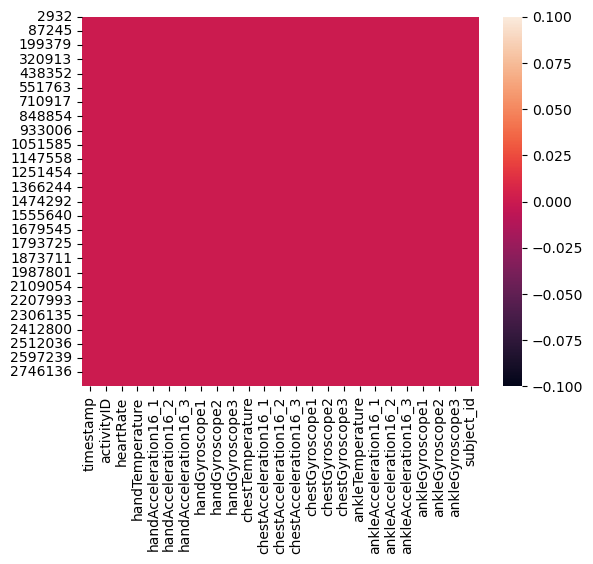

In [12]:
sns.heatmap(dfTreated.isnull())
plt.show()

Evidently from the heat map, we have no null / missing values

In [13]:
#Rechecking the null values for each column in the treated dataset - 'dfTreated'...
dfTreated.isnull().sum().sort_values(ascending=False)

timestamp                0
chestAcceleration16_3    0
ankleGyroscope3          0
ankleGyroscope2          0
ankleGyroscope1          0
ankleAcceleration16_3    0
ankleAcceleration16_2    0
ankleAcceleration16_1    0
ankleTemperature         0
chestGyroscope3          0
chestGyroscope2          0
chestGyroscope1          0
chestAcceleration16_2    0
activityID               0
chestAcceleration16_1    0
chestTemperature         0
handGyroscope3           0
handGyroscope2           0
handGyroscope1           0
handAcceleration16_3     0
handAcceleration16_2     0
handAcceleration16_1     0
handTemperature          0
heartRate                0
subject_id               0
dtype: int64

We see from the above that after data treatment, we have no null values in our dataset

### 2.2 Calculating Resultant Acceleration and Resultant Angular Velocity

Furthermore, we can combine acceleration and gyroscope measurements by finding the resultant acceleration and resultant angular velocity (gyroscope data) for hand, chest and ankle separately. The resultant values calculated will be captured in new columns, whereas, the individual acceleration and the angular velocity measurements dropped. 

Resultant acceleration, $a_{(res)} = \sqrt {a_x^2 \, +\, a_y^2 \,+\, a_z^2}$

Resultant angular velocity, $\omega_{(res)} = \sqrt {\omega_x^2 \, +\, \omega_y^2 \,+\, \omega_z^2}$

In [14]:
#Calculating the resultant acceleration, and angular velocity for hand, chest and ankle described above...

dfTreated['handAcceleration'] = ((dfTreated.handAcceleration16_1**2)+(dfTreated.handAcceleration16_2**2)+(dfTreated.handAcceleration16_3**2))**0.5
dfTreated['chestAcceleration'] = ((dfTreated.chestAcceleration16_1**2)+(dfTreated.chestAcceleration16_2**2)+(dfTreated.chestAcceleration16_3**2))**0.5
dfTreated['ankleAcceleration'] = ((dfTreated.ankleAcceleration16_1**2)+(dfTreated.ankleAcceleration16_2**2)+(dfTreated.ankleAcceleration16_3**2))**0.5
dfTreated['handGyroscope'] = ((dfTreated.handGyroscope1**2)+(dfTreated.handGyroscope2**2)+(dfTreated.handGyroscope3**2))**0.5
dfTreated['chestGyroscope'] = ((dfTreated.chestGyroscope1**2)+(dfTreated.chestGyroscope2**2)+(dfTreated.chestGyroscope3**2))**0.5
dfTreated['ankleGyroscope'] = ((dfTreated.ankleGyroscope1**2)+(dfTreated.ankleGyroscope2**2)+(dfTreated.ankleGyroscope3**2))**0.5

In [15]:
#Dropping all of the individual acceleration,angularvelocity and magneticfield measurements and
dfTreated = dfTreated.drop(['handAcceleration16_1','handAcceleration16_2','handAcceleration16_3',
           'chestAcceleration16_1','chestAcceleration16_2','chestAcceleration16_3',
           'ankleAcceleration16_1','ankleAcceleration16_2','ankleAcceleration16_3',
           'handGyroscope1','handGyroscope2','handGyroscope3',
           'chestGyroscope1','chestGyroscope2','chestGyroscope3',
           'ankleGyroscope1','ankleGyroscope2','ankleGyroscope3'], axis=1)

In [16]:
dfTreated

,timestamp,activityID,heartRate,handTemperature,chestTemperature,ankleTemperature,subject_id,handAcceleration,chestAcceleration,ankleAcceleration,handGyroscope,chestGyroscope,ankleGyroscope
2932,37.70,1,100.0,30.375,32.1875,30.75,1,9.751993,9.875840,9.956473,0.072467,0.041521,0.049304
2943,37.81,1,100.0,30.375,32.1875,30.75,1,9.583806,9.859305,9.946165,0.435808,0.058315,0.024230
2954,37.92,1,100.0,30.375,32.1875,30.75,1,9.639631,9.798303,9.911287,0.081883,0.072202,0.022479
2965,38.03,1,100.0,30.375,32.1875,30.75,1,10.045489,9.929907,9.760667,0.374651,0.071764,0.016725
2976,38.14,1,101.0,30.375,32.1875,30.75,1,9.963993,9.804206,9.888575,0.378423,0.059240,0.067042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871975,94.66,24,162.0,25.125,32.3750,31.50,9,10.876780,9.884364,10.063054,0.157022,0.100384,0.037724
2871986,94.77,24,162.0,25.125,32.3750,31.50,9,10.341491,9.895226,9.792079,0.458881,0.162803,0.010443
2871997,94.88,24,162.0,25.125,32.3750,31.50,9,10.021582,9.915689,9.809462,0.415535,0.310067,0.051387
2872007,94.98,24,162.0,25.125,32.3750,31.50,9,9.932805,10.178812,9.947890,0.388336,0.322284,0.042514


The data frame above shows the combination of all hand acceleration columns, chest acceleration columns, and ankle acceleration columns. Also the combination of all hand angular velocity columns, chest angular velocity columns and ankle angular velocity columns have been represented in the data frame.

In [17]:
# #Removing about five seconds from the data when switching from one activity to another...

# #Counts each change when acitvity changes and make cumilative sum and saved as a row in the dataframe
# dfTreated['activityBlock'] = ((dfTreated['activityID'].shift(1) != dfTreated['activityID']) & (dfTreated['subject_id'].shift(1) == dfTreated['subject_id'])).astype(int).cumsum() 
# dropIndex = []
# #For the total number of change
# numblocks = dfTreated['activityBlock'].max()
# #For each point in the dataframe where activity changes, 50 rows are added (corresponding to five seconds) to the droplist
# for block in range(1, numblocks+1):
#     dropIndex += list(dfTreated[dfTreated['activityBlock']==block].head(10 * 5).index)
#     dropIndex += list(dfTreated[dfTreated['activityBlock']==block].tail(10 * 5).index)
# #The rows in the droplist is droped, i.e., 5 seconds in each shift of activities is removed    
# dfTreated = dfTreated.drop(dropIndex)
# dfTreated.drop(['activityBlock'], axis = 1, inplace  = True)
# dfTreated.reset_index(drop=True, inplace=True)
# dfTreated

Checking the percentage of data retained after completeing the above steps

In [18]:
len(dfTreated)/len(dfRaw) * 100

6.176012599333062

After the data treatment / cleaning processes above, we ratined about 6 percent of our data.

## 3.0 Exploratory Data Analysis And Visualizations
Examining the data, to see if we can find any interesting statistics and observations. To achieve this, the data is further split into test and train. On the train data, we will perform EDA, and on the test data, we will perform hypothesis testing.

### 3.1 Balance Analysis
Before you split your data into a training set and a testing set, it is important to assess the balance of your dataset. If your dataset is imbalanced, it can affect the performance of your model and the validity of your results. Hence, this analysis is necessary to check for each subject if there are equal number of samples

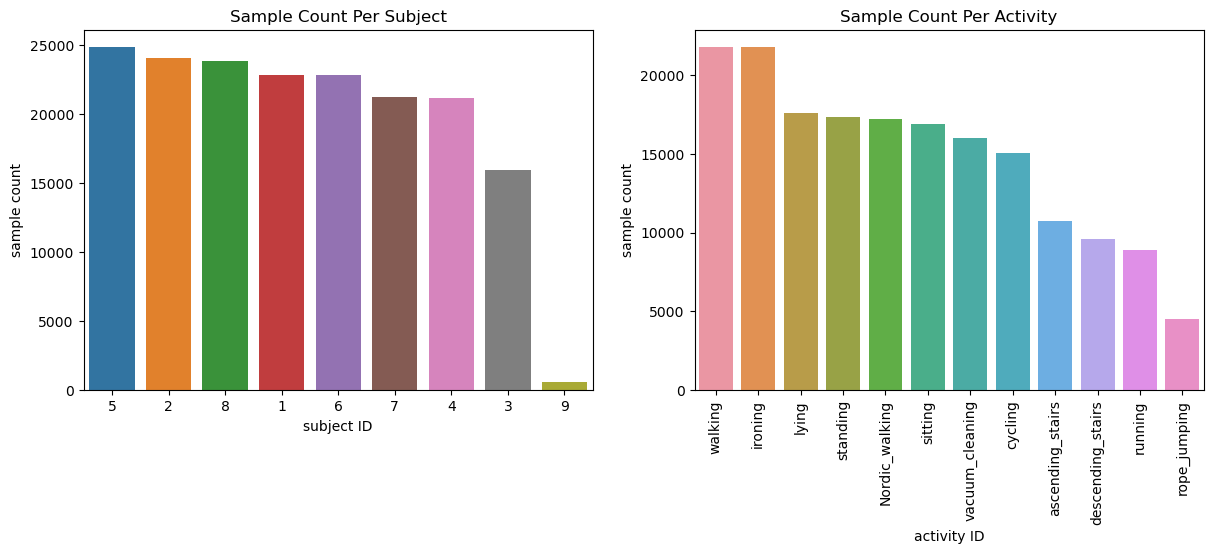

In [19]:
plt.subplots_adjust(1,0,2.75,0.75)

plt.subplot(121)
descend = dfTreated.groupby('subject_id').size().sort_values().index[::-1]
sns.countplot(x='subject_id', data=dfTreated, order=descend)
plt.title("Sample Count Per Subject")
plt.xlabel('subject ID')
plt.ylabel('sample count')

plt.subplot(122)
descend = dfTreated.groupby('activityID').size().sort_values().index[::-1]
a =[activityID_dict[i] for i in descend]
s = sns.countplot(x='activityID', data=dfTreated, order=descend)
s.set_xticklabels(a, rotation=90)
plt.title("Sample Count Per Activity")
plt.xlabel('activity ID')
plt.ylabel('sample count')

plt.show()

We can see from the chart above that the data isn't balanced:
* Subject 9 has less samples then all others subjects, while subject 5 had the most samples.
* Rope_jumping (activity 24) has the least number of samples than other activities, and walking recorded the most samples.

However, the only disadvantage to that is the fact that if the researcher lays too much emphasis on one subgroup, the result could be skewed.

### 3.2 Data Splitting

Data splitting is the process of dividing a dataset into separate training and test sets. The training set is used to train a machine learning model, while the test set is used to evaluate the model's performance on unseen data. There are several different methods for splitting data, but for this case we are adopting the Stratified sampling which is useful when the classes are imbalanced.

In [20]:
#The split percentage that will be employed is 80% for the train set and 20% for the test set, 
#which is the most typical split used.
dfTrain = dfTreated.sample(frac=0.8, random_state=1)
dfTest = dfTreated.drop(dfTrain.index)

In [21]:
dfTrain

,timestamp,activityID,heartRate,handTemperature,chestTemperature,ankleTemperature,subject_id,handAcceleration,chestAcceleration,ankleAcceleration,handGyroscope,chestGyroscope,ankleGyroscope
68817,696.55,3,98.0,33.0000,34.6250,33.3750,1,9.849247,9.701193,9.831735,0.055663,0.019209,0.035965
2773370,3179.34,7,117.0,30.6875,33.8125,31.8125,8,3.768636,4.899456,9.293140,0.755839,0.469348,1.119186
2622702,1672.66,12,98.0,34.3750,38.0625,34.3125,8,15.689417,14.417261,8.611949,3.647789,1.885233,4.855775
331735,3325.73,5,173.0,30.3750,33.6875,33.0000,1,11.102513,9.566765,23.534973,5.211004,3.488922,2.143105
1747730,3424.74,5,161.0,33.8125,36.4375,34.0625,5,10.947063,0.632507,16.168164,0.950638,0.724282,2.931711
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880404,1003.84,17,94.0,33.9375,36.3125,35.0000,6,6.488687,10.221807,9.936002,3.038962,0.504451,0.257418
1756819,3515.63,5,168.0,33.8125,36.4375,34.0625,5,18.947467,17.636388,7.127737,2.239039,2.468520,7.658168
91282,921.20,17,95.0,33.2500,35.0625,33.8750,1,8.925970,10.072270,9.888537,1.999493,0.358600,0.116877
2547441,920.05,17,86.0,34.6875,37.8125,34.6250,8,8.095979,9.556632,10.100330,0.997330,1.278140,0.623104


### 3.3 Summary Statistics
Summary statistics are used to give a quick overview of a large dataset and to identify patterns or trends in the data. They can also be used to compare different datasets or groups of data.

In [22]:
dfTrain.describe()

,timestamp,activityID,heartRate,handTemperature,chestTemperature,ankleTemperature,subject_id,handAcceleration,chestAcceleration,ankleAcceleration,handGyroscope,chestGyroscope,ankleGyroscope
count,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000,141926.000000
mean,1705.094311,8.078034,107.490044,32.749716,36.178089,33.711993,4.565569,10.991668,10.200550,12.404378,1.515040,0.520830,1.429680
std,1093.879660,6.175274,26.990819,1.794006,1.494018,1.091315,2.335595,5.732630,3.867411,7.766630,1.715356,0.593134,1.913037
min,31.220000,1.000000,57.000000,24.875000,31.937500,30.000000,1.000000,0.278204,0.220936,0.326540,0.001588,0.001402,0.000579
25%,742.772500,3.000000,86.000000,31.687500,35.187500,33.000000,2.000000,9.444194,9.471611,9.859592,0.168618,0.095711,0.058374
50%,1479.530000,6.000000,105.000000,33.125000,36.437500,34.062500,5.000000,9.800118,9.829702,10.045199,0.986604,0.368505,0.537875
75%,2665.130000,13.000000,124.000000,34.062500,37.437500,34.500000,7.000000,11.276136,10.402262,11.730005,2.240869,0.706778,2.140915
max,4245.650000,24.000000,202.000000,35.500000,38.562500,35.437500,9.000000,178.922859,127.143562,200.641542,19.163110,15.775153,14.580009


Based on the descriptive stats above for the train data, Heart Rate ranged between $57/min$ to $202/min$ with a mean value of $\approx 107/min$.

Also, temperature measurements for hand, chest and ankle ranges between $24.9 ^\circ$ to about $38.6 ^\circ $, with the maximum value recorded for chest temperature and minimum observed for hand temperature.

Also, mean acceleration measurements for hand, chest and ankle ranges between $10.2 \, m^2/sec$ to about $12.5 \, m^2/sec$, with the maximum value recorded for ankle acceleration and minimum observed for chest acceleration.

Also, mean angular velocity measurements for hand, chest and ankle ranges between $0.54 \, rad/sec$ to about $1.56 \, rad/sec$, with the maximum value recorded for hand and minimum observed for chest.

### 3.4 Heart Rate Anlysis

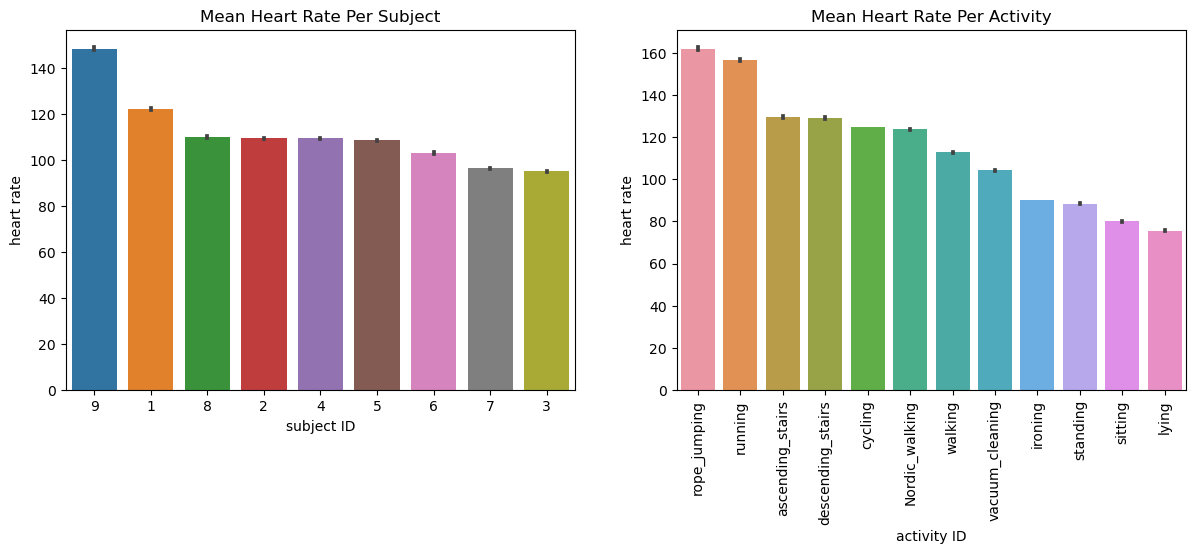

In [23]:
plt.subplots_adjust(1,0,2.75,0.75)

plt.subplot(121)
dfTrain_HR = dfTrain['heartRate'].groupby(dfTrain["subject_id"]).mean().sort_values().index[::-1]
sns.barplot(x='subject_id', data=dfTreated, y="heartRate", order=dfTrain_HR)
plt.title("Mean Heart Rate Per Subject")
plt.xlabel('subject ID')
plt.ylabel('heart rate')

plt.subplot(122)
dfTrain_HR = dfTrain['heartRate'].groupby(dfTrain["activityID"]).mean().sort_values().index[::-1]
a =[activityID_dict[i] for i in dfTrain_HR]
s = sns.barplot(x='activityID', data=dfTrain, y="heartRate", order=dfTrain_HR)
s.set_xticklabels(a, rotation=90)
plt.title("Mean Heart Rate Per Activity")
plt.xlabel('activity ID')
plt.ylabel('heart rate')

plt.show()

From the charts above, subject 9 has the highest heart rate compared to the other subjects. Whereas, for the activities, the above bar graph makes it clear that the average heart rate is on the lower end of the spectrum and is rather close to the normal heart rate of $72 bpm$ for physically easy activities like ironing, standing, sitting and lying. However, activities that are only moderately physically demanding, such as cycling, Nordic Walking, and climbing and descending stairs, have an average heart rate of above $120 bpm$. On the other hand, with vigorous movements of the body during hard exercise like jogging and rope jumping, the average heart rate is over $150 bpm$.

### 3.5 Tempature Analysis
Temperature analysis is the process of measuring and analyzing the temperature of a system or object in order to understand and characterize its behavior. Temperature analysis can be used to identify trends and patterns, optimize processes, troubleshoot problems, and make predictions about future behavior. 

In [24]:
#To see how the temperature data description of the hand for different activitites
dfAll_Temp = dfTrain[['handTemperature','chestTemperature','ankleTemperature']].groupby(dfTrain['activityID']) 
dfAll_Temp_sumStat = dfAll_Temp.describe()
# To change the index to the real index
dfAll_Temp_sumStat.index = dfAll_Temp.describe().index.map(activityID_dict)
dfAll_Temp_sumStat

handTemperature                                         \
                            count       mean       std      min      25%   
activityID                                                                 
lying                     14101.0  32.732067  1.404955  30.1875  31.3125   
sitting                   13503.0  33.266162  1.103005  31.5000  32.1875   
standing                  13927.0  33.638916  0.855892  32.1875  33.0000   
walking                   17403.0  32.294685  1.378107  28.6875  31.3125   
running                    7131.0  30.815160  2.095377  27.9375  28.8125   
cycling                   12027.0  31.007691  1.994362  27.5625  29.3125   
Nordic_walking            13818.0  31.527517  1.752760  28.9375  30.3125   
ascending_stairs           8601.0  33.527744  0.873469  31.7500  32.5625   
descending_stairs          7585.0  33.322322  0.882146  31.5625  32.4375   
vacuum_cleaning           12869.0  34.177418  0.651571  33.0625  33.6875   
ironing                   17335.0  34.017351  0.772009  32.6250  33.4375   
rope_jumping               3626.0  29.733384  2.497353  24.8750  28.4375   

                                             chestTemperature             \
                       50%      75%      max            count       mean   
activityID                                                                 
lying              32.8750  33.8125  34.9375          14101.0  35.093265   
sitting            33.5000  34.2500  35.0625          13503.0  35.829001   
standing           33.5625  34.2500  35.2500          13927.0  36.165968   
walking            32.5625  33.0625  34.8750          17403.0  37.004439   
running            30.8125  33.8125  33.8750           7131.0  34.400110   
cycling            31.0625  32.7500  34.6875          12027.0  35.724937   
Nordic_walking     30.7500  33.0000  34.9375          13818.0  36.149393   
ascending_stairs   33.7500  34.1250  35.1250           8601.0  37.054739   
descending_stairs  33.5625  33.8750  34.8750           7585.0  37.016809   
vacuum_cleaning    34.1250  34.6250  35.5000          12869.0  37.057158   
ironing            33.9375  34.6875  35.5000          17335.0  36.662626   
rope_jumping       30.1875  30.8125  33.8750           3626.0  33.616071   

                                                                          \
                        std      min      25%      50%      75%      max   
activityID                                                                 
lying              1.560447  32.1875  33.6250  34.9375  36.6875  37.4375   
sitting            1.254178  33.6875  34.8125  35.7500  37.0000  37.6250   
standing           1.068390  34.3125  35.2500  35.9375  37.4375  37.6875   
walking            0.826353  35.2500  36.4375  37.1250  37.6250  38.4375   
running            1.434701  32.0625  33.3750  34.0625  36.3750  36.8125   
cycling            1.601728  32.8125  34.5000  35.3750  37.3750  38.3125   
Nordic_walking     1.673125  33.7500  34.8125  35.6875  38.3125  38.5625   
ascending_stairs   0.869834  35.1875  36.6875  36.8750  37.8125  38.1875   
descending_stairs  0.787120  35.4375  36.6875  36.7500  37.8125  38.0000   
vacuum_cleaning    0.892455  35.5000  36.5000  37.1875  37.9375  38.2500   
ironing            0.929151  34.9375  36.0000  36.4375  37.6250  38.1250   
rope_jumping       1.476330  31.9375  32.1875  33.7500  34.1250  36.5000   

                  ankleTemperature                                         \
                             count       mean       std      min      25%   
activityID                                                                  
lying                      14101.0  32.981105  1.422343  30.0000  31.6875   
sitting                    13503.0  33.640865  0.951201  31.2500  32.8750   
standing                   13927.0  33.896652  0.835660  31.8125  33.3125   
walking                    17403.0  33.840933  0.916256  31.8750  33.1875   
running                     7131.0  33.143160  0.949214 

It is clear from the aforementioned data frame that vacuum cleaning averaged the highest temperature for hand, chest and ankle. This observation maybe as a result of the hot air the machine emits. Similar mean temperatures are found for all other physically easy activities. 

It's also noteworthy that the hand temperature is significantly lower during vigorous hand movement activities than it is during other activities;  Jumping rope: 29.75°C; Cycling: 30.98°C; Running: 30.82°C. This can be attributed to the high air movement around the hand during these activities, which may have created a high rate of heat transfer from the hand to the air, which could be one explanation for this result.

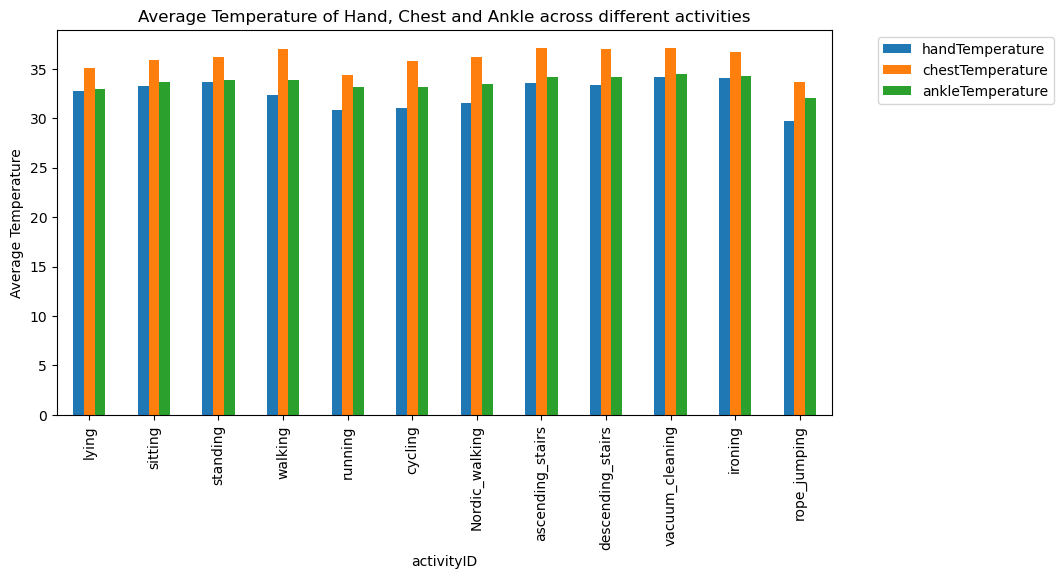

In [25]:
# To find the hand,chest and ankle average temperatures
dfHand_Temp = dfTrain['handTemperature'].groupby(dfTrain['activityID']).mean()  
dfChest_Temp = dfTrain['chestTemperature'].groupby(dfTrain['activityID']).mean()
dfAnkle_Temp = dfTrain['ankleTemperature'].groupby(dfTrain['activityID']).mean()

dfHand_Temp.index = dfHand_Temp.index.map(activityID_dict)
dfChest_Temp.index = dfChest_Temp.index.map(activityID_dict)
dfAnkle_Temp.index = dfAnkle_Temp.index.map(activityID_dict)

# concatenating the different means togather so that it can be plotted in the same plot as a tripple bar graph
dfTemperature_avg = pd.concat([dfHand_Temp,dfChest_Temp,dfAnkle_Temp],axis = 1)
dfTemperature_avg.plot(kind = 'bar', figsize = (10,5))
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.ylabel('Average Temperature')
plt.title('Average Temperature of Hand, Chest and Ankle across different activities')
plt.show()

The above chart shows an aggreement with the summary statistics above. Hand temperatures were significantly lower for highly vigorous hand movement activities like jumping rope, Cycling and Running. 

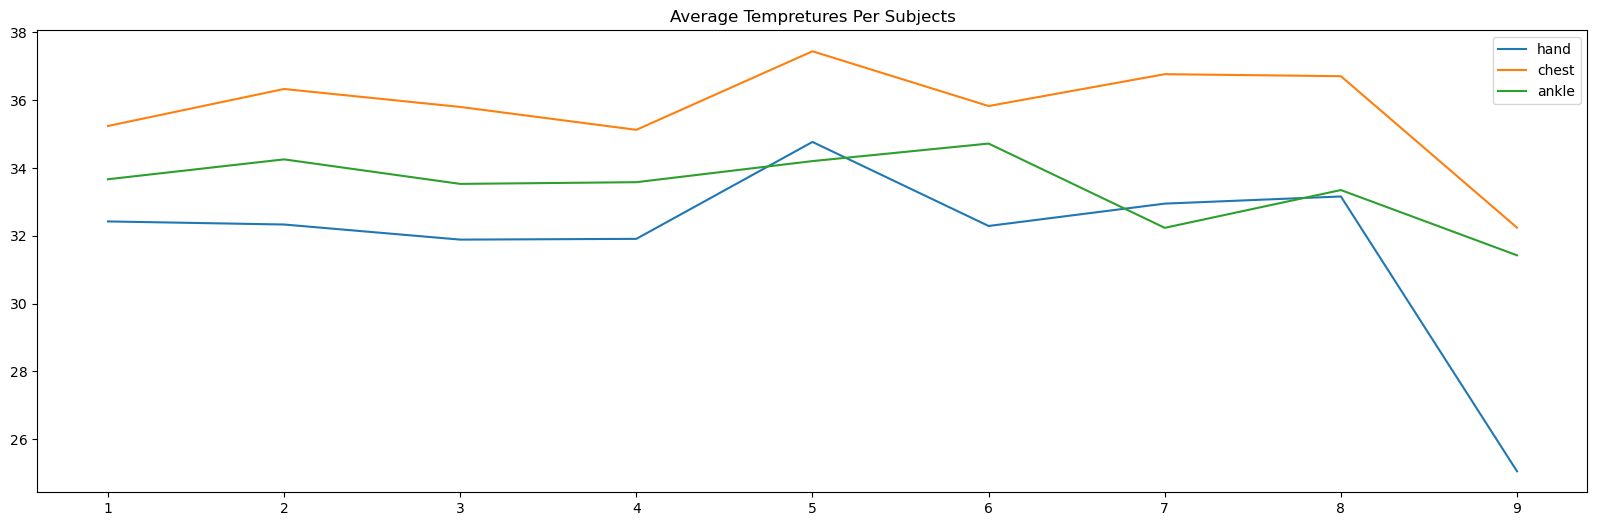

In [26]:
uniqueIDs = dfTrain.groupby(['subject_id']).mean().reset_index()

dfTemperature = pd.DataFrame()
dfTemperature['hand'] = uniqueIDs['handTemperature']
dfTemperature['chest'] = uniqueIDs['chestTemperature']
dfTemperature['ankle'] = uniqueIDs['ankleTemperature']

ax = dfTemperature.plot(kind='line', figsize=(20,6), title='Average Tempretures Per Subjects')
ax.set_xticklabels(uniqueIDs['subject_id'])
ax.legend(fontsize = 10)
ax.set_xticks(np.arange(len(dfTemperature)))
plt.show()

With respect to subjects, we can see that suject 9 has the lowest mean tempetures for the three positioned sensors (hand, chest and ankle) measured.

### 3.6 Acceleration analysis
Acceleration analysis is the study of how an object's acceleration changes over time. It involves calculating the rate of change of an object's velocity, which is the derivative of velocity with respect to time. 

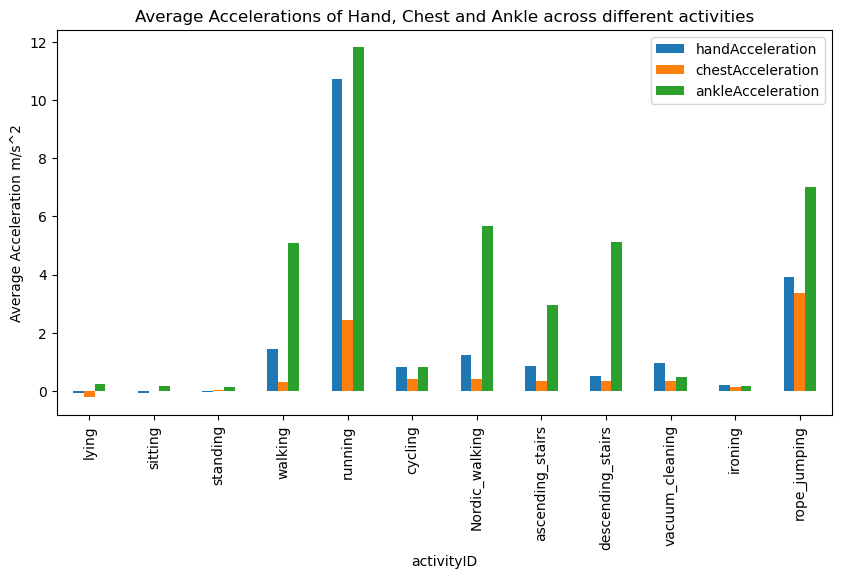

In [27]:
# To find the hand,chest and ankle average accelaration
# Gravitational acceleration (9.81) is subtracted from each values in order to improve the depiction of the body part's movement vigour when charting.
dfHand_Acc = dfTrain['handAcceleration'].groupby(dfTrain['activityID']).mean() - 9.81 
dfChest_Acc = dfTrain['chestAcceleration'].groupby(dfTrain['activityID']).mean() - 9.81
dfAnkle_Acc = dfTrain['ankleAcceleration'].groupby(dfTrain['activityID']).mean() - 9.81

dfHand_Acc.index = dfHand_Acc.index.map(activityID_dict)
dfChest_Acc.index = dfChest_Acc.index.map(activityID_dict)
dfAnkle_Acc.index = dfAnkle_Acc.index.map(activityID_dict)

# concating the different means togather so that it can be plotted in the same plot as a tripple bar graph
dfAcceleration_avg = pd.concat([dfHand_Acc,dfChest_Acc,dfAnkle_Acc],axis = 1)
dfAcceleration_avg.plot(kind = 'bar', figsize = (10,5))
plt.ylabel('Average Acceleration m/s^2')
plt.title('Average Accelerations of Hand, Chest and Ankle across different activities')
plt.show()

The mean acceleration of various body parts is quite low during physically undemanding tasks (sleeping, sitting, standing, ironing), as is to be expected. Running and rope jumping, however, have physically demanding activities like ankle and hand mean acceleration values that are noticeably high. Cycling is an exception, as it doesn't require as much leg mobility as walking, Nordic walking, or rising and descending stairs. With the exception of rope jumping and running, practically all activities have low chest acceleration.

### 3.7 Angular velocity analysis
Angular velocity is a measure of the rate at which an object rotates around a point or an axis. It is typically denoted by the symbol omega (ω) and is measured in radians per second (rad/s).

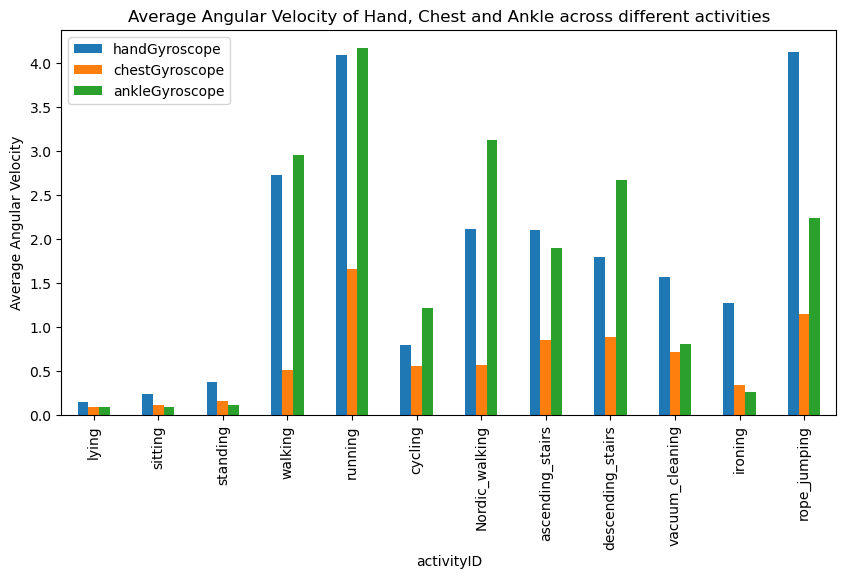

In [28]:
# To find the hand,chest and ankle average temperatures
dfHand_AngVel = dfTrain['handGyroscope'].groupby(dfTrain['activityID']).mean()  
dfChest_AngVel = dfTrain['chestGyroscope'].groupby(dfTrain['activityID']).mean()
dfAnkle_AngVel = dfTrain['ankleGyroscope'].groupby(dfTrain['activityID']).mean()

dfHand_AngVel.index = dfHand_AngVel.index.map(activityID_dict)
dfChest_AngVel.index = dfChest_AngVel.index.map(activityID_dict)
dfAnkle_AngVel.index = dfAnkle_AngVel.index.map(activityID_dict)

# Concatenating the different means togather so that it can be plotted in the same plot as a tripple bar graph
dfAngVel_avg = pd.concat([dfHand_AngVel,dfChest_AngVel,dfAnkle_AngVel],axis = 1)
dfAngVel_avg.plot(kind = 'bar', figsize = (10,5))
plt.ylabel('Average Angular Velocity')
plt.title('Average Angular Velocity of Hand, Chest and Ankle across different activities')
plt.show()

Except for ironing, which has a significant mean angular acceleration in the hand, physically undemanding activities have low angular velocities for each body part, as can be seen from the above bar chart. Running has a high mean angular acceleration for the hand and ankle (4.2rad/sec). The largest mean hand angular acceleration occurs during rope leaping (4.5rad/sec), while ankle acceleration is very slow compared to hand acceleration. The mean ankle velocity is substantially higher going down stairs than going up.

### 3.8 Sensor Analysis
Sensor analysis refers to the process of evaluating and interpreting data collected by sensors. Sensor analysis can be used in a variety of applications, including health monitoring.

In [29]:
#Exploring the average values of all the sensor data for different subject ID
# pivoting the table with respect to the subject ID
dfMean = dfTrain.pivot_table(index='subject_id')
dfMean = dfMean.drop(["activityID","timestamp"],axis = 1)
dfMean

,ankleAcceleration,ankleGyroscope,ankleTemperature,chestAcceleration,chestGyroscope,chestTemperature,handAcceleration,handGyroscope,handTemperature,heartRate
subject_id,,,,,,,,,,
1,12.613012,1.400300,33.667876,10.302390,0.579408,35.238564,11.179297,1.688628,32.423884,122.302059
2,12.160482,1.517965,34.254049,10.224044,0.596029,36.329774,10.818192,1.835693,32.332976,109.592873
3,11.786505,0.999310,33.530801,9.940457,0.395654,35.800403,10.682006,1.468212,31.887581,95.046416
4,11.581570,1.162349,33.581195,9.994052,0.451524,35.125472,10.279740,1.189798,31.909696,109.357853
5,12.846668,1.608244,34.203253,10.329820,0.546795,37.442117,11.095179,1.522842,34.768169,108.474464
6,12.578789,1.563441,34.720111,10.183602,0.609790,35.827700,11.939162,1.681059,32.289608,103.068764
7,12.481160,1.445724,32.235016,10.026194,0.412709,36.766594,10.414043,1.042343,32.949067,96.339431
8,12.772193,1.545705,33.349282,10.411444,0.505248,36.707491,11.253402,1.561773,33.159516,109.839771
9,17.521260,2.210743,31.424601,12.644138,1.051567,32.239495,14.087466,3.067980,25.054920,148.755319


Having a glance at the dataframe above, subject ID 9 happens to show the highest mean values for all sensory data, with the exception of temperature data, and a very high mean heart rate of 147.59 bpm. However, this data is heavily skewed because subject 9 has only participated in one protocol activity—rope jumping. Other contenders also have similar heart rates if we only take rope leaping into account.

In [30]:
#Exploring the average value of sensor data for different activities
#Pivoting the table with respect to the activity ID
dfMean_activity = dfTrain.pivot_table(index = 'activityID')
dfMean_activity.index  = dfMean_activity.index.map(activityID_dict)
dfMean_activity=dfMean_activity.drop(['subject_id'],axis = 1)
dfMean_activity

,ankleAcceleration,ankleGyroscope,ankleTemperature,chestAcceleration,chestGyroscope,chestTemperature,handAcceleration,handGyroscope,handTemperature,heartRate,timestamp
activityID,,,,,,,,,,,
lying,10.061194,0.092012,32.981105,9.588401,0.094124,35.093265,9.727403,0.151788,32.732067,75.531310,205.850482
sitting,9.967515,0.095302,33.640865,9.818999,0.115328,35.829001,9.753517,0.243859,33.266162,80.033918,506.510255
standing,9.952429,0.112667,33.896652,9.836456,0.158201,36.165968,9.775886,0.373467,33.638916,88.511740,732.981550
walking,14.907163,2.960087,33.840933,10.126148,0.515730,37.004439,11.261583,2.728421,32.294685,112.802390,2429.260349
running,21.615107,4.167381,33.143160,12.252771,1.659568,34.400110,20.532867,4.087860,30.815160,156.503295,3444.092422
cycling,10.637162,1.220326,33.170561,10.213148,0.559410,35.724937,10.642257,0.798797,31.007691,124.819406,3128.516791
Nordic_walking,15.496463,3.120516,33.444321,10.222161,0.562689,36.149393,11.043161,2.112659,31.527517,123.816616,2905.772210
ascending_stairs,12.772740,1.899278,34.176349,10.150155,0.856046,37.054739,10.666193,2.101297,33.527744,129.746890,1808.024297
descending_stairs,14.940593,2.669559,34.174868,10.169157,0.886600,37.016809,10.340545,1.792820,33.322322,129.177587,1906.726765


The key finding from this table is that temperature is the only sensor data that is not at its maximum for rope jumping, which had the highest values for all other captured readings. Also, all sensor data, with the exception of ankle acceleration and temperature, were minimal for lying activities.

### 3.8.1 Correleation analysis for all the sensor data.
Correlation analysis can be used to analyze the relationship between sensor data and other variables.

Since the majority of sensor data distribution does not follow a normal distribution, we must utilise the Spearman correlation method to determine the correlation.

In [31]:
#Ridding unsuitable columns for the correlation analysis
dfTrain_corr = dfTrain.drop(['subject_id','activityID','timestamp'],axis =1)
#Running the spearman correlation
dfTrain_corr.corr(method = 'spearman').style.background_gradient()

,heartRate,handTemperature,chestTemperature,ankleTemperature,handAcceleration,chestAcceleration,ankleAcceleration,handGyroscope,chestGyroscope,ankleGyroscope
heartRate,1.000000,-0.346925,-0.040121,-0.056197,0.168648,0.086825,0.254717,0.609616,0.645223,0.692476
handTemperature,-0.346925,1.000000,0.743749,0.503030,-0.116877,0.020019,-0.113165,-0.157177,-0.138704,-0.254107
chestTemperature,-0.040121,0.743749,1.000000,0.451462,-0.045319,0.073205,0.043990,0.120575,0.094162,0.125284
ankleTemperature,-0.056197,0.503030,0.451462,1.000000,-0.007623,0.048268,-0.043878,0.122279,0.075102,-0.006643
handAcceleration,0.168648,-0.116877,-0.045319,-0.007623,1.000000,0.386504,0.165352,0.238789,0.214349,0.171814
chestAcceleration,0.086825,0.020019,0.073205,0.048268,0.386504,1.000000,0.199923,0.063910,0.130067,0.093713
ankleAcceleration,0.254717,-0.113165,0.043990,-0.043878,0.165352,0.199923,1.000000,0.209017,0.244250,0.383080
handGyroscope,0.609616,-0.157177,0.120575,0.122279,0.238789,0.063910,0.209017,1.000000,0.718811,0.694865
chestGyroscope,0.645223,-0.138704,0.094162,0.075102,0.214349,0.130067,0.244250,0.718811,1.000000,0.723575
ankleGyroscope,0.692476,-0.254107,0.125284,-0.006643,0.171814,0.093713,0.383080,0.694865,0.723575,1.000000


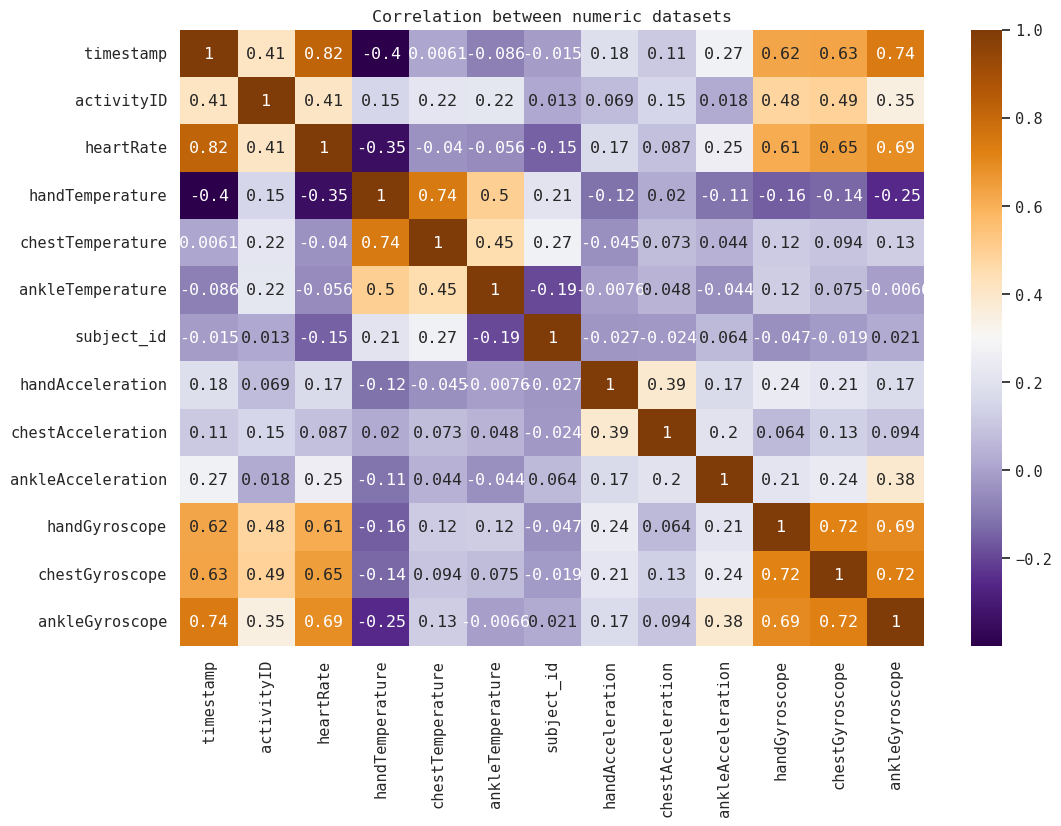

In [89]:
# #Heatmap using seaborn for representing the same correlation data frame we saw before

# sns.set(font = 'monospace')
# dfTrain_corr = dfTrain.corr(method='spearman')
# fig, axe = plt.subplots(figsize=(12,8))

# # cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
# # sns.heatmap(dfTrain_corr,vmax=1,square =True, cmap=cmap,annot=True );

# sns.heatmap(dfTrain_corr, cmap='PuOr_r', annot=True)
# plt.title("Correlation between numeric datasets")
# plt.show()

It can be seen from the correlation data frame above that there is a strong correlation between the heart rate and all measurements of angular velocity (hand, chest, and ankle). 

Another intriguing observation is the negative correlation between heart rate and hand temperature $(-0.35)$, heart rate and chest temperature $(-0.04)$ and heart rate and ankle temperature $(-0.06)$.

Even though there is a positive correlation between the acceleration measurments, there is not a strong correlation.

There is a positive correlation noticeable between all of the temperature measurements.

All measures of angular velocity are highly positively correlated with one another.

## 4.0 Hypothesis testing
The goal of hypothesis testing is to determine whether the hypothesis is true or false based on sample data.

Defining a function to calculate the correlation and p-values...

In [33]:
"""
Since the hypothesis is based on correlation from a non-normally distributed data, 
we adopt the spearmanr method from scipy.stats module
"""
def hypothesis_testCorr(data1,data2):
    #spearmanr gives correlation and p_value as output
    correlation,p_value = spearmanr(data1,data2)
    print(f'correlation between the parameters = {correlation}')
    print(f'p_value = {p_value}')
    for k in [0.01 , 0.05, 0.1]:
        if p_value < k:
            print(f'The null Hypothesis H0 is rejected at a confidence interval of {100 -k*100}% and the alternate hypothesis is accepted')
            break

        else:
            print(f'Failed to reject the null Hypothesis at {100-k*100}% confidence interval')

### 4.1.1 Hypothesis 1 
High hand angular velocity should results in high heart rates

Hypothesis: If hand angular velocity correlates positively with heart rates, then for high hand angular velocity, heart rate should be high

Null Hypothesis (𝐻0): Correlation = 0

Alternate Hypothesis (𝐻1): Correleation> 0

In [34]:
#Calling the defined hypothesis function on the hand angular velocity and heart rate data
hypothesis_testCorr(dfTest['handGyroscope'],dfTest['heartRate']) 

correlation between the parameters = 0.6084874162065737
p_value = 0.0
The null Hypothesis H0 is rejected at a confidence interval of 99.0% and the alternate hypothesis is accepted


According to the results of the above hypothesis testing, there is a statistically significant positive link between the hand's angular velocity and heart rate.

### 4.1.2 Hypothesis 2
High chest angular velocity should results in high heart rates

Hypothesis: If chest angular velocity correlates positively with heart rates, then for high chest angular velocity, heart rate should be high

Null Hypothesis (𝐻0): Correlation = 0

Alternate Hypothesis (𝐻1): Correleation> 0

In [35]:
#Calling the defined hypothesis function on the chest angular velocity and heart rate data
hypothesis_testCorr(dfTest['chestGyroscope'],dfTest['heartRate']) 

correlation between the parameters = 0.646883525617938
p_value = 0.0
The null Hypothesis H0 is rejected at a confidence interval of 99.0% and the alternate hypothesis is accepted


According to the results of the above hypothesis testing, there is a statistically significant positive link between the chest's angular velocity and heart rate.

### 4.1.3 Hypothesis 3
High ankle angular velocity should results in high heart rates

Hypothesis: If ankle angular velocity correlates positively with heart rates, then for high ankle angular velocity, heart rate should be high

Null Hypothesis (𝐻0): Correlation = 0

Alternate Hypothesis (𝐻1): Correleation> 0

In [36]:
#Calling the defined hypothesis function on the angular velocity and heart rate data
hypothesis_testCorr(dfTest['ankleGyroscope'],dfTest['heartRate']) 

correlation between the parameters = 0.6957905635933749
p_value = 0.0
The null Hypothesis H0 is rejected at a confidence interval of 99.0% and the alternate hypothesis is accepted


According to the results of the above hypothesis testing, there is a statistically significant positive link between the ankle's angular velocity and heart rate.

Based on the results of all three hypothesis tests above, we can say that a person's heart rate will typically increase when their limbs (hand and legs), and chest move with greater vigour.

## 5.0 Modelling
Models are often used to simulate, predict, or analyze the behavior of the system they represent. Modeling can be a powerful tool for understanding complex systems and making informed decisions about them. Our goal is to contribute to the creation of technology and software for tracking human activities. To do that, we need to create and test a model that can be used to forecast an individual's activity using sensor data.

Models would be created using acceleration, heart rate and gyroscope data

### 5.1 Importing all necessary modelling modules

In [37]:
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# just to get the list of 12 activities which are protocol activities
actList = list(dfHand_AngVel.index)
#actList

### 5.2 Data preparation and function defination for model

In [39]:
#Shuffling the dataset
dfTreated_mod = dfTreated.sample(frac = 1, random_state = 33)

#Dropping timestamp and subject id
dfTreated_mod = dfTreated_mod.drop(['timestamp','subject_id'],axis = 1)

#features dataframe
dfFeature = dfTreated_mod.drop(['activityID'],axis = 1)
#target dataframe
dfTarget = dfTreated_mod['activityID']

In [40]:
#Robust scaler is used since the data is skewed and not normally distributed
scaler = RobustScaler()
#test train split
x_train,x_test,y_train,y_test = train_test_split(dfFeature,dfTarget,test_size = 0.2,random_state = 42)
#scaling the train data
x_train = scaler.fit_transform(x_train)
#scaling the train data using the same scalar object
x_test = scaler.transform(x_test)

In [41]:
"""
Function to get accuracy,precision,Recall and F1 score of the data
"""
def getMetrics (y_obs,y_forc):
    accuracy = accuracy_score(y_obs, y_forc)
    #Average precision
    precision = precision_score(y_obs,y_forc,average=None).mean()
    #Average recall
    recall = recall_score(y_obs,y_forc,average=None).mean()
    #Average f1 score
    f1 = f1_score(y_obs,y_forc,average=None).mean()
   
    print("Accuracy:  ",accuracy)
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F1:        ", f1)

In [42]:
"""
Function to show the confusion matrix
"""
def show_confusionMatrix(y_obs,y_forc):  
    cMatrix = confusion_matrix(y_obs,y_forc)
    #setting the scale to get bigger display
    plt.rcParams['figure.figsize'] = (10,7)
    disp = ConfusionMatrixDisplay(confusion_matrix= cMatrix, display_labels = actList)
    disp.plot(xticks_rotation= 'vertical',cmap = 'binary' )
    plt.show()

### 5.3 Dimensionality reduction using Principal Component Analysis (PCA)
The goal of PCA is to reduce the number of dimensions in the data while preserving as much of the information as possible. This can be useful when working with high-dimensional datasets, as it can reduce the complexity of the data and make it easier to visualize and analyze.

Usually, 90–98% of the variation will adequately explain our results. Therefore, we might determine how many of them we could utilise by graphing the variance ratio against the number of components. The graph below shows that 15 components account for almost 94% of the variance.

Given the large number of features, training and testing may take a long time for the model to complete. However, we can use PCA (principle component analysis) to project and minimise the dimension of the features, potentially shortening the time between training and testing.

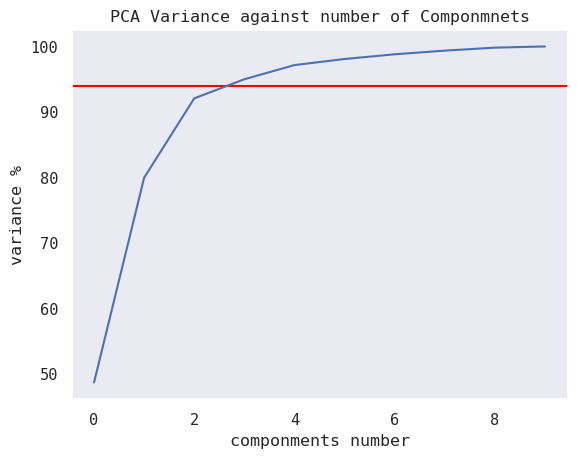

In [43]:
from sklearn.decomposition import PCA

pca = PCA()
#Fitting the train data...
pca.fit(x_train)
#To explains the amount of variance that the number of components can capture...
var= pca.explained_variance_ratio_ 
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against number of Componmnets")
plt.ylabel("variance %")
plt.xlabel("componments number")
#How many components we must take into account to capture 94% variance will be revealed at the intersection of the line and the curve.
line_incpt = plt.axhline(94, color="red")

plt.plot(var1)
plt.grid()

We can observe from the following graph that both lines intersect at x = 3, which indicates that for our data, 3 features are required to capture 94% of the variation.

### 5.4 SVC model using PCA
Support Vector Machines (SVMs) are a type of supervised machine learning algorithm that can be used for classification or regression tasks.

Principal Component Analysis (PCA) as explained earlier is a dimensionality reduction technique that can be used to reduce the number of features in a dataset. It does this by finding a new set of dimensions (called "principal components") that are orthogonal to each other and that capture as much of the variation in the data as possible.

One way to use PCA with an SVM is to first reduce the dimensionality of the dataset using PCA, and then train the SVM on the lower-dimensional dataset. This can help to reduce the complexity of the model, as well as to improve its generalization performance.

In [44]:
#Creating PCA object for 3 features, based on the PCA dimension reduction carried out above...
pca = PCA(n_components=3)
#Fitting X_train
x_train=pca.fit_transform(x_train)
#Using the same pca object to transform x_test
x_test=pca.transform(x_test)

In [45]:
#PCA_1,PCA_2,PCA_3 are the 3 columns created by the PCA object
x_train_df = pd.DataFrame(x_train,columns=['PCA_1','PCA_2','PCA_3' ])
#x_train_df

In [46]:
%%time
from sklearn.svm import SVC

svcModel = SVC(kernel = 'rbf')
svcModel.fit(x_train, y_train)

Wall time: 20min 42s


SVC()

It can be observed that the SVC model takes about 19 mins to train the data with PCA approach

In [47]:
%%time
svcModel_y_forc = svcModel.predict(x_test)

print(len(svcModel_y_forc))
print(len(y_test))
print(svcModel_y_forc[0:5])
print(y_test[0:5])

getMetrics(y_test,svcModel_y_forc)

35482
35482
[ 3 17 16 17  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.42669522574826674
Precision:  0.44672029568250965
Recall:     0.39149542374499996
F1:         0.37278319549455646
Wall time: 11min 13s


On the other hand, it takes about 11 mins 13s to test the data with PCA approach.

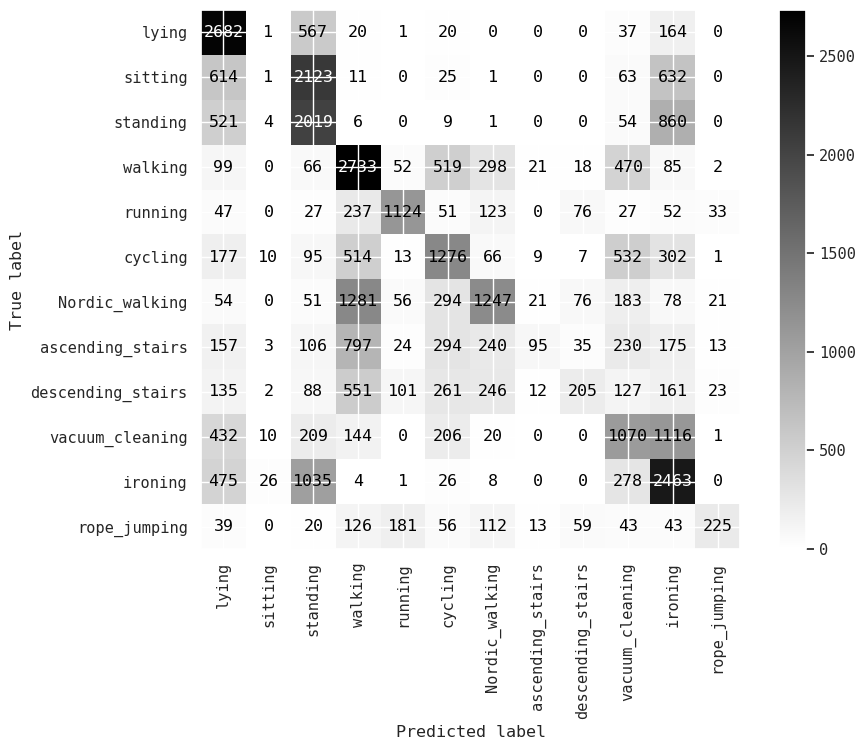

In [48]:
#shows the confusion matrix
show_confusionMatrix(y_test,svcModel_y_forc)

Here by using SVM model with PCA we get very low scores. Let us check if it is because of the implementation of the PCA

### 5.5 SVC model without using PCA
Support Vector Classification (SVC) is a type of supervised learning algorithm that is used for classification tasks. It is a linear model that works by finding the hyperplane in a high-dimensional space that maximally separates the classes.

Overall, the SVC model is a powerful tool for classification tasks, particularly in cases where the data is not easily separable in a lower-dimensional space.

In [49]:
#shuffling the dataset
dfTreated_mod2 = dfTreated.sample(frac = 1, random_state = 33)
#Dropping timestamp and subject ID
dfTreated_mod2 = dfTreated_mod2.drop(['timestamp','subject_id'],axis = 1)
#features dataframe
dfFeature = dfTreated_mod2.drop(['activityID'],axis = 1)
#target dataframe
dfTarget = dfTreated_mod2['activityID']

In [50]:
#Robust scaler is used since the data is skewed and not normally distributed
scaler = RobustScaler()
#test train split
xx_train,xx_test,yy_train,yy_test = train_test_split(dfFeature,dfTarget,test_size = 0.2,random_state = 42)
#scaling the train data
xx_train = scaler.fit_transform(xx_train)
#scaling the train data using the same scalar object
xx_test = scaler.transform(xx_test)

In [51]:
%%time
svcModel = SVC(kernel = 'rbf')
svcModel.fit(xx_train, yy_train)

Wall time: 16min 55s


SVC()

Now, we can observe that fitting and training the SVC model only took about 10 minutes. compared to the 19 minutes it took with PCA approach. This observation is not as we would have expected the result of this two approaches to varry, as PCA should reduce the time taken given the expected reduction in the dimension of our data. However, this wasn't the case with our observation.

In [52]:
%%time
svcModel_y_forc2 = svcModel.predict(xx_test)

print(len(svcModel_y_forc2))
print(len(y_test))
print(svcModel_y_forc2[0:5])
print(y_test[0:5])

getMetrics(yy_test,svcModel_y_forc2)

35482
35482
[13 16 16  3  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.770644270334254
Precision:  0.7798086302585027
Recall:     0.7541662458881611
F1:         0.7620052463038104
Wall time: 7min 53s


Similar to the observation with the train data, we had a time reduction compared to when we used the PCA approach. Overall, it took about 7 mins to test the data without the PCA approach.

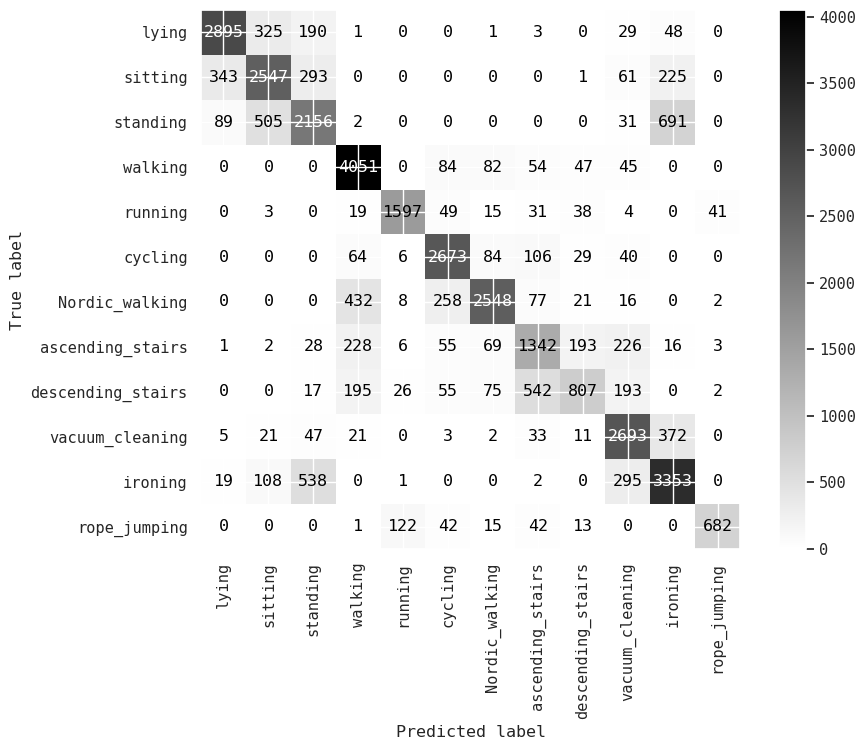

In [53]:
#shows the confusion matrix
show_confusionMatrix(yy_test,svcModel_y_forc2)

We obtain an accuracy of $\approx$ $80.35$ % without performing dimensionality reduction (using PCA ), which is a pretty substantial difference to the $\approx$ $44.71$ % obtained with PCA. Based on the significant difference in accuracy values, going forward, we will stick to running this analysis without PCA. Also, unexpectedly the analysis with PCA takes much longer than running the SVM without PCA

### 5.6 Random Forest vs Logistic Regression model
Random forests and logistic regression are two different types of machine learning models that can be used for classification tasks.
#### 5.6.1 Random Forest Classifier Model
Random forests are a type of ensemble model, which means that they use multiple decision trees to make predictions. These decision trees are trained on different parts of the training data and then the results are combined to make a final prediction. Random forests are generally more accurate and robust than individual decision trees, because they can reduce overfitting and improve generalization to new data. However, they can also be more computationally expensive to train and use than simpler models like logistic regression.

In [54]:
%%time
#creating the model object
randFC = RandomForestClassifier()
randFC.fit(xx_train,yy_train)

randFC_y_forc = randFC.predict(xx_test)

print(len(randFC_y_forc))
print(len(yy_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(yy_test[0:5])

getMetrics(yy_test,randFC_y_forc)

35482
35482
[13 17 16  3  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.9971534862747309
Precision:  0.9966819748368803
Recall:     0.9966991860033825
F1:         0.9966887929474071
Wall time: 52.8 s


Random Forest Classifier model only takes about 1min 40 second to trian our model where as SVM model took over 23 mins.

Random Forest Classifier model has nearly perfect scores(accuracy = 99.71% ) by using all the sensor data as the input

#### 5.6.2 Logistic Regression Model
Logistic regression, on the other hand, is a linear model that is used for classification. It is trained to predict the probability that an example belongs to a particular class, and then makes a prediction based on whether that probability is above or below a certain threshold. Logistic regression is relatively simple and easy to interpret, and it is often used as a baseline model for classification tasks. However, it can struggle to capture complex nonlinear relationships in the data, so it may not perform as well as more powerful models like random forests on some tasks.

In [55]:
%%time
logRM = LogisticRegression()
logRM.fit(X=xx_train, y=yy_train )

logRM_y_forc = logRM.predict(xx_test)

print(len(logRM_y_forc))
print(len(yy_test))
print(logRM_y_forc[0:5]) #comparing values of the first 5 predictions
print(yy_test[0:5])

getMetrics(yy_test, logRM_y_forc)

35482
35482
[16 16 16  2  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.6229919395749958
Precision:  0.6130694988165205
Recall:     0.6038198446436113
F1:         0.6045935763907722
Wall time: 12.3 s


Despite the shorter execution time for the logistic regression model (about 11.7 seconds), it gave a way lesser accuracy, 62.3% compared to the result of the random forest classifier.

### 5.7.1 Applying random forest classifier to our dataset, without gyroscope data

In [56]:
#dropping subject ID, timestamp and gyroscope data
dfTreated_randFC = dfTreated.drop(['subject_id','timestamp','handGyroscope','chestGyroscope','ankleGyroscope'],axis = 1)

In [57]:
dfFeatures3 = dfTreated_randFC.drop(['activityID'],axis = 1)
dfTarget3 = dfTreated_randFC['activityID']

In [58]:
scaler = RobustScaler()
x_train,x_test,y_train,y_test = train_test_split(dfFeatures3,dfTarget3,test_size = 0.2,random_state = 42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [59]:
%%time
randFC = RandomForestClassifier()
randFC.fit(x_train,y_train)

Wall time: 25.1 s


RandomForestClassifier()

In [60]:
%%time
randFC_y_forc = randFC.predict(x_test)

print(len(randFC_y_forc))
print(len(y_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(y_test[0:5])

getMetrics(y_test,randFC_y_forc)

35482
35482
[ 5  1 16 17  6]
2114271     5
2166203     1
973135     16
2227352    17
1716930     6
Name: activityID, dtype: int64
Accuracy:   0.9963079871484133
Precision:  0.9952060424913401
Recall:     0.9948276718309595
F1:         0.9950110825366197
Wall time: 1.06 s


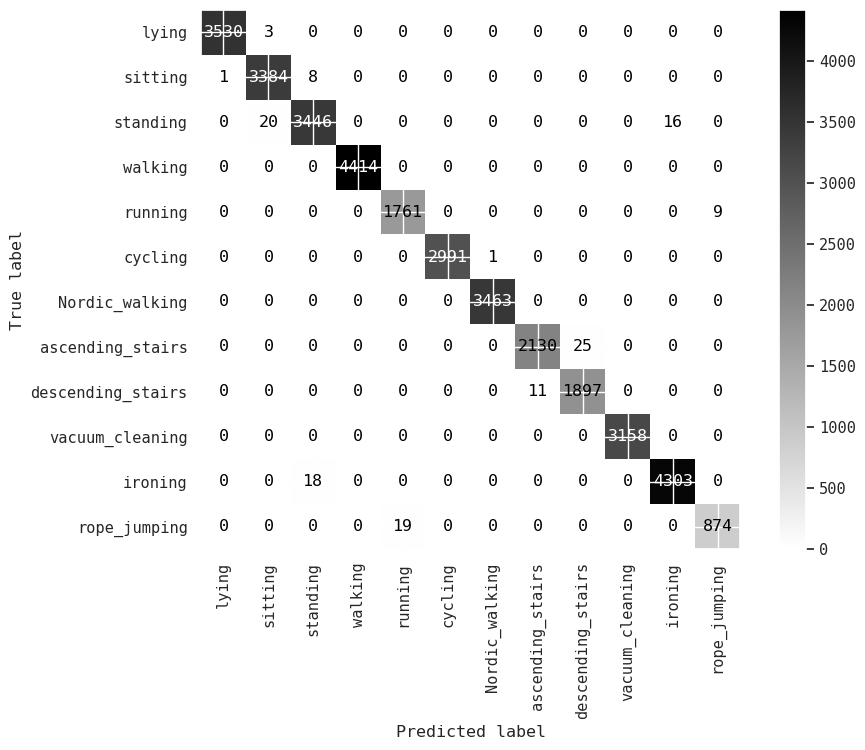

In [61]:
show_confusionMatrix(y_test,randFC_y_forc)

Even yet, we still achieved a very high accuracy rating (99.63%) despite not using all the sensors. However, the confusion matrix shows that a large portion of the rope-jumping action is now categorised as running since gyroscope sensor data is not there. Therefore, it is not a good idea to avoid the gyroscope sensor if a person is very physically active because it would misidentify the heavy actions.

However, we don't need to include the gyroscope in the hardware if the person doesn't engage in heavy activities that require rapid limb motions.

###  5.7.2 Applying random forest classifier to our dataset, without temperature sensor data

In [62]:
dfTreated_randFC2 = dfTreated.drop(['subject_id','timestamp','handTemperature','chestTemperature','ankleTemperature'],axis = 1)

In [63]:
dfFeatures4 = dfTreated_randFC2.drop(['activityID'],axis = 1)
dfTarget4 = dfTreated_randFC2['activityID']

In [64]:
scaler = RobustScaler()
x_train,x_test,y_train,y_test = train_test_split(dfFeatures4,dfTarget4,test_size = 0.2,random_state = 42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [65]:
%%time
randFC = RandomForestClassifier()
randFC.fit(x_train,y_train)

Wall time: 47.5 s


RandomForestClassifier()

In [66]:
%%time
randFC_y_forc = randFC.predict(x_test)

print(len(randFC_y_forc))
print(len(y_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(y_test[0:5])

getMetrics(y_test,randFC_y_forc)

35482
35482
[ 5  1 16 17  6]
2114271     5
2166203     1
973135     16
2227352    17
1716930     6
Name: activityID, dtype: int64
Accuracy:   0.7311030945268023
Precision:  0.7372214768661625
Recall:     0.715022577434398
F1:         0.722518406717874
Wall time: 1.7 s


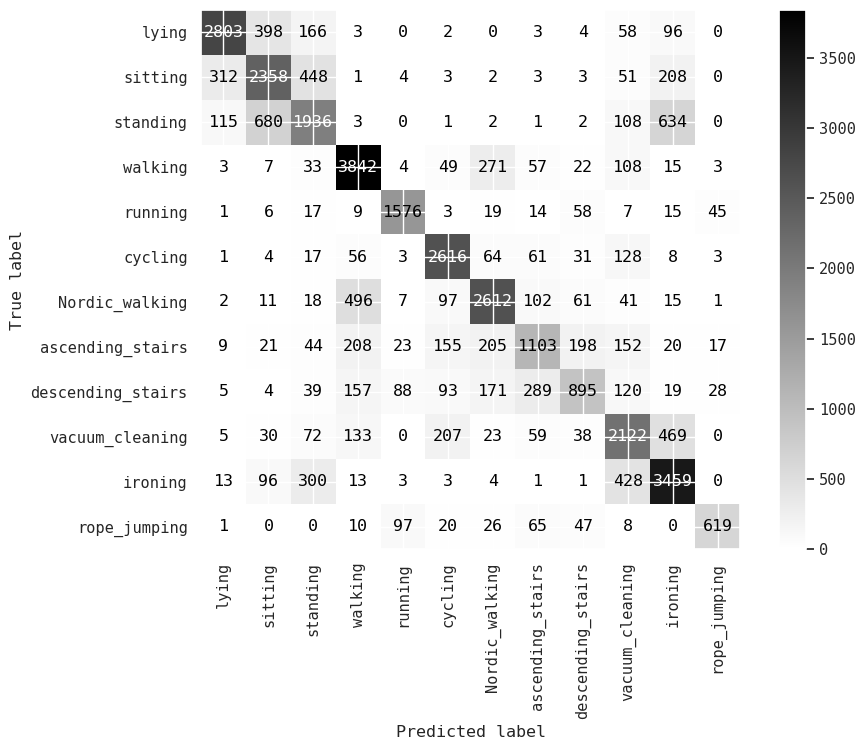

In [67]:
show_confusionMatrix(y_test,randFC_y_forc)

We may therefore conclude from the observation above that removing the temperature sensor reduces the model's ability to accurately categorise the activities.  Therefore, it is safe to consider the use of a temperature sensor to be essential hardware. 

### 5.8 Location of Hardware/sensors

It is not possible to wear sensors in every part of the body at this time since we are working to develop hardware that can classify activities. Therefore, we should attach the device to the hand or ankle. It should be held in the hand if we are merely comparing convenience between these two positions. Nevertheless, we need to still determine whether there is a significant difference in accuracy between the two positions.

### 5.8.1 Applying random forest classifier to our dataset, for hand-held hardware

In [68]:
#Shuffling the dataset
dfTreated_mod = dfTreated.sample(frac = 1, random_state = 33)

In [69]:
#Dropping sensor data from chest and ankle
dfTreated_Hand = dfTreated_mod.drop(['timestamp','subject_id','chestAcceleration','ankleAcceleration','chestTemperature','ankleTemperature','chestGyroscope','ankleGyroscope'],axis = 1)

In [70]:
dfFeatures5 = dfTreated_Hand.drop(['activityID'],axis = 1)
dfTarget5 = dfTreated_Hand['activityID']

In [71]:
scaler = RobustScaler()
x_train,x_test,y_train,y_test = train_test_split(dfFeatures5,dfTarget5,test_size = 0.2,random_state = 42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [72]:
%%time
randFC = RandomForestClassifier()
randFC.fit(x_train,y_train)

Wall time: 30 s


RandomForestClassifier()

In [73]:
%%time
randFC_y_forc = randFC.predict(x_test)

print(len(randFC_y_forc))
print(len(y_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(y_test[0:5])

getMetrics(y_test,randFC_y_forc)

35482
35482
[13 16 16  3  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.9140972887661349
Precision:  0.9165833390206736
Recall:     0.9096054035399508
F1:         0.912861998753411
Wall time: 1.4 s


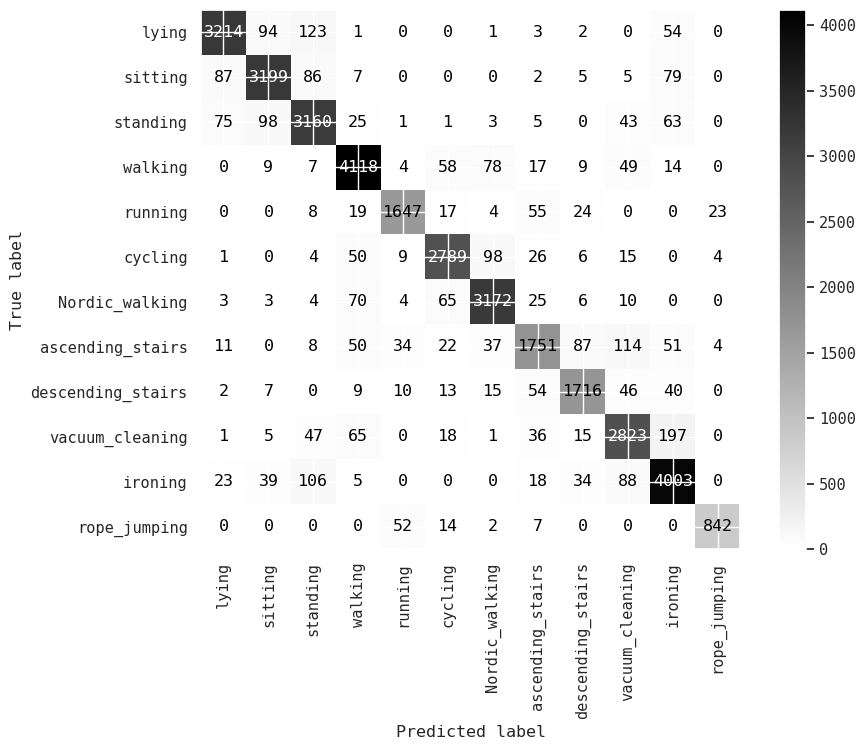

In [74]:
show_confusionMatrix(y_test,randFC_y_forc)

### 5.8.2 Applying random forest classifier to our dataset, for ankle-held hardware

In [75]:
#Dropping sensor data from chest and hand
dfTreated_Ankle = dfTreated_mod.drop(['timestamp','subject_id','chestAcceleration','handAcceleration','chestTemperature','handTemperature','chestGyroscope','handGyroscope'],axis = 1)

In [76]:
dfFeatures6 = dfTreated_Ankle.drop(['activityID'],axis = 1)
dfTarget6 = dfTreated_Ankle['activityID']

In [77]:
scaler = RobustScaler()
x_train,x_test,y_train,y_test = train_test_split(dfFeatures6,dfTarget6,test_size = 0.2,random_state = 42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [78]:
%%time
randFC = RandomForestClassifier()
randFC.fit(x_train,y_train)

Wall time: 31.5 s


RandomForestClassifier()

In [79]:
%%time
randFC_y_forc = randFC.predict(x_test)

print(len(randFC_y_forc))
print(len(y_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(y_test[0:5])

getMetrics(y_test,randFC_y_forc)

35482
35482
[13 17  3  3  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.8919452116566147
Precision:  0.8925552357862027
Recall:     0.8834122290955553
F1:         0.8872204453628075
Wall time: 1.43 s


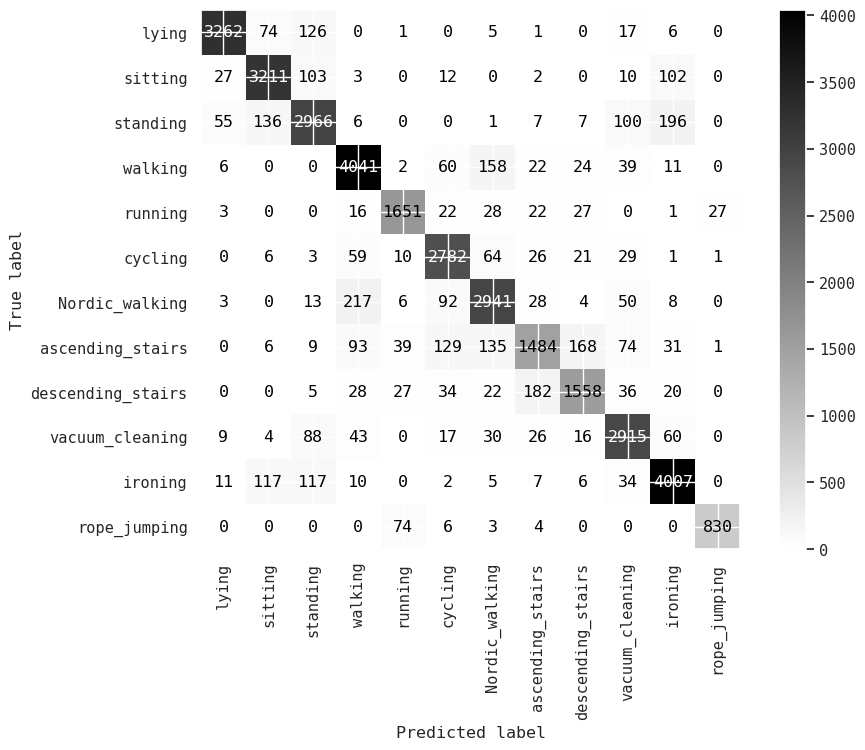

In [80]:
show_confusionMatrix(y_test,randFC_y_forc)

### 5.8.3 Applying random forest classifier to our dataset, for chest-held hardware

In [81]:
#Dropping sensor data from hand and ankle
dfTreated_Chest = dfTreated_mod.drop(['timestamp','subject_id','ankleAcceleration','handAcceleration','ankleTemperature','handTemperature','ankleGyroscope','handGyroscope'],axis = 1)

In [82]:
dfFeatures7 = dfTreated_Chest.drop(['activityID'],axis = 1)
dfTarget7 = dfTreated_Chest['activityID']

In [83]:
scaler = RobustScaler()
x_train,x_test,y_train,y_test = train_test_split(dfFeatures7,dfTarget7,test_size = 0.2,random_state = 42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [84]:
%%time
randFC = RandomForestClassifier()
randFC.fit(x_train,y_train)

Wall time: 30.7 s


RandomForestClassifier()

In [85]:
%%time
randFC_y_forc = randFC.predict(x_test)

print(len(randFC_y_forc))
print(len(y_test))
print(randFC_y_forc[0:5]) #comparing values of the first 5 predictions
print(y_test[0:5])

getMetrics(y_test,randFC_y_forc)

35482
35482
[13 17 16  3  7]
180346     13
468725     17
1552567    16
2216032     3
713258      7
Name: activityID, dtype: int64
Accuracy:   0.9068541795840144
Precision:  0.9082043421312899
Recall:     0.9035321674749405
F1:         0.9056559552402993
Wall time: 1.37 s


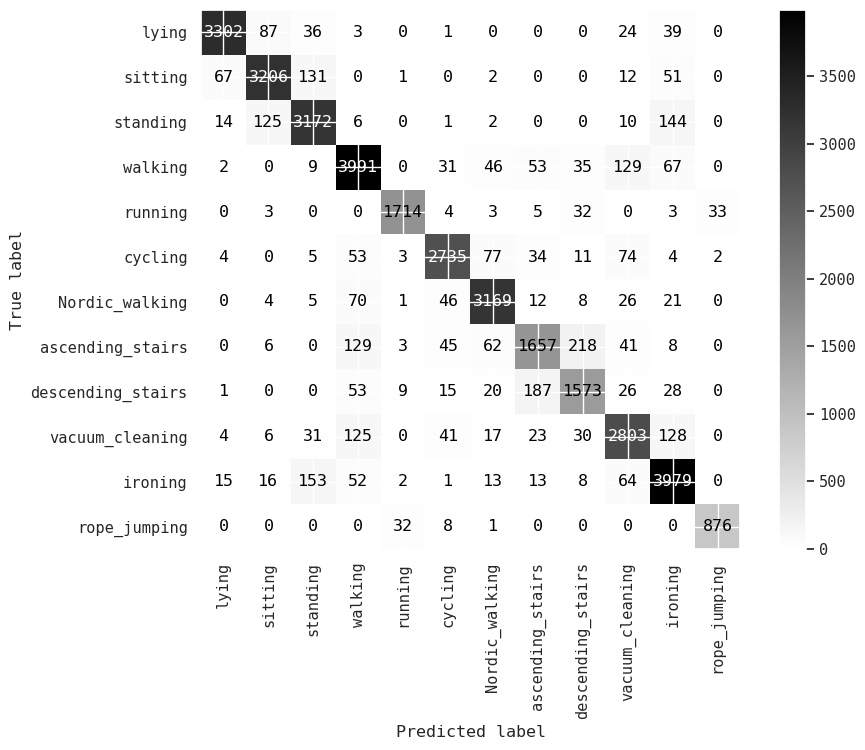

In [86]:
show_confusionMatrix(y_test,randFC_y_forc)

According to the models above using a random forest classifier, placing the hardware in the ankle and chest will have an accuracy of $89.88$ % and $91.22$ % respectively. These accuracy values were lesser compared to the $92.18$ % accuracy value obtained for hardware placed on the hand. Therefore, I recommend that the hardware be made so that it can be worn in the user's hand.

## 6.0 Conclusion
Analysis of the PAMAP2 Physical Activity Monitoring dataset has shown a number of interesting findings. The exploitation of various sensor data results in the ability to use the sensor data collectively as features to aid in the development of hardware and software that can anticipate the activity carried out by the person out of the 12 protocol activities.

In order to confirm that our findings from exploratory data analysis are statistically significant, hypothesis testing is done on the test data set.

The adoption of the Random Forest Classifier (randFC) model, proved to be more accurate and efficient compared to support vector machine model (SVM) model. The randFC model took very low time to compute and returned a model with a very high accuracy. Other models used were the Logistic regression, which averagely required short time to compute, however lesser accuracy compared to the random forest classifier model.

In conclusion, based on the findings from this report, Random Forest Classifier should be the adopted model for the development of a commercial hardware geared towards categorising the activities carried out by a person, and hardware should be created to be worn in the hand.

## References

1. Archive.ics.uci.edu. (2012). UCI Machine Learning Repository: PAMAP2 Physical Activity Monitoring Data Set. [online] Available at: http://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring
2. Talk accelerometer Available at:https://en.wikipedia.org/wiki/Talk%3AAccelerometer.

In [92]:
import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="DSRM Report 2 - Richard.ipynb"
question_count=23

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 3981


In [1]:
pip install nbconvert[webpdf]

     ---------------------------------------- 83.4/83.4 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 101.4/101.4 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install jupyter

Note: you may need to restart the kernel to use updated packages.


In [9]:
jupyter nbconvert --to pdf mynotebook.ipynb

SyntaxError: invalid syntax (804559335.py, line 1)